In [176]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy.spatial import distance
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from scipy import linalg

%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from scipy import stats 
from sklearn import datasets 
from sklearn.naive_bayes import GaussianNB 
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.model_selection import train_test_split


In [177]:
colors = ['green','gray','navy', 'turquoise', 'darkorange','red','yellow','pink']
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

### Pregled na podatocnoto mnozestvo

<IPython.core.display.Javascript object>


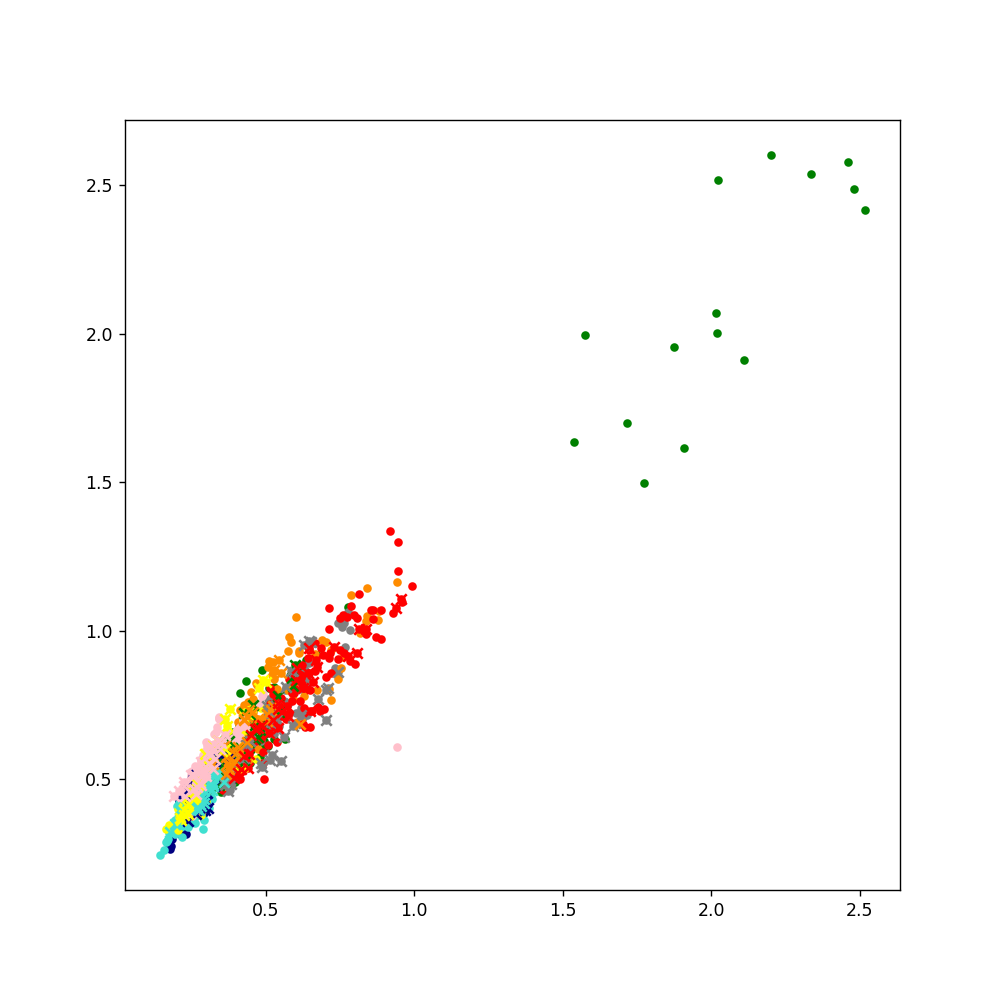

In [183]:
d.dropna()
iris = np.array(d)
target_names = ['c-CS-s','c-CS-m','c-SC-s','c-SC-m','t-CS-s','t-CS-m','t-SC-s','t-SC-m']


skf = StratifiedKFold(n_splits=4)
train_index, test_index = next(iter(skf.split(iris[:,1:-4], iris[:,-1])))

idata=iris[:,1:-4]
itar=iris[:,-1]

X = idata
y=itar
X_train = idata[train_index]
y_train = itar[train_index]
X_test = idata[test_index]
y_test = itar[test_index]



n_classes = len(np.unique(y_train))
plt.figure(figsize=(8,8))
for n, color in zip(target_names,colors):
    data = idata[itar == n]
    plt.scatter(data[:, 0], data[:, 1], s=15.5, color=color)
for n, color in zip(target_names,colors):
    data = X_test[y_test == n]
    plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)
plt.show()


### PCA za podatocnoto mnozestvo i vizuelizacija 
#### Mozi da se zabelezi od samiot grafik nekoja separabilnost pomegju podatocite vo ramki na klasteri soodvetni na izleznite klasi

<IPython.core.display.Javascript object>


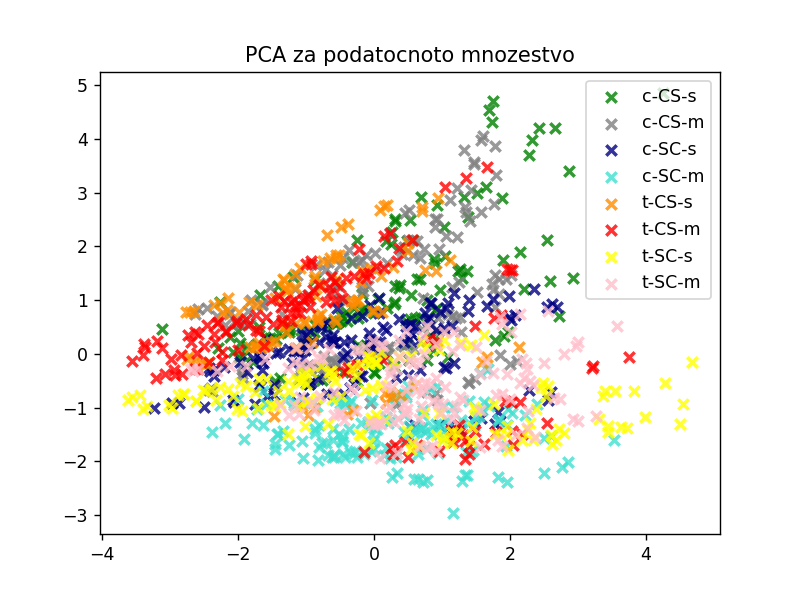

In [184]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X)
SimpleImputer()
X2=imp_mean.transform(X)

pca = PCA(n_components=2) #Setiranje na brojot na komponentite na 2 za da se pretstavi soodvetno vo 2D prostor 
X_PCA = pca.fit(X2).transform(X2)  
X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(X_PCA, y, test_size=0.30, random_state=42) #Soodvetno istoto go pravime za PCA dataset-ot


plt.figure() 
for color, i, target_name in zip(colors, target_names,target_names):
    plt.scatter(X_PCA[y == i, 0], X_PCA[y == i, 1], marker='x', color=color, alpha=.8, lw=2,label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA za podatocnoto mnozestvo')
plt.show()


### Klasteriranje so metodot na Gaussian Mixture Models 

<IPython.core.display.Javascript object>


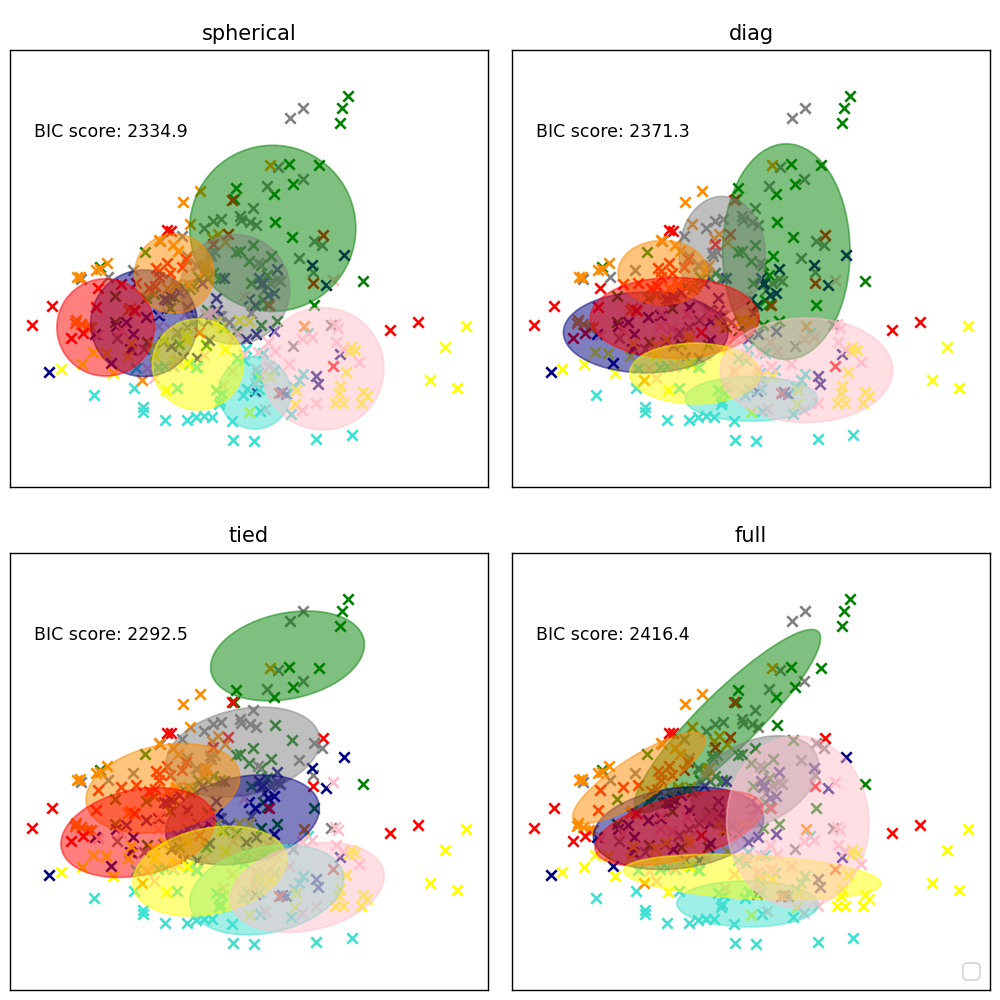

No handles with labels found to put in legend.


In [197]:
# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=8,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(4 * n_estimators // 2, 8))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)

for index, (name, estimator) in enumerate(estimators.items()):
    estimator.means_init = np.array([X_PCA_train[y_PCA_train == i].mean(axis=0)
                                    for i in target_names])
    
    estimator.fit(X_PCA_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    
    # Plot the test data with crosses
    for n, color in zip(target_names,colors):
        data = X_PCA_test[y_PCA_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)


    plt.text(0.05, 0.8, 'BIC score: %.1f' % estimator.bic(X_PCA_test),
             transform=h.transAxes)
    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.show()

### Klasteriranje so K-means modelot, pri sto dobivame separabilnost megju klasterite so minimalni slicnosti kako pri prethodniot model na GMM

Najgolema slicnost imame so GMM modelot kade koristime sfericni kovarijansni matrici

<IPython.core.display.Javascript object>


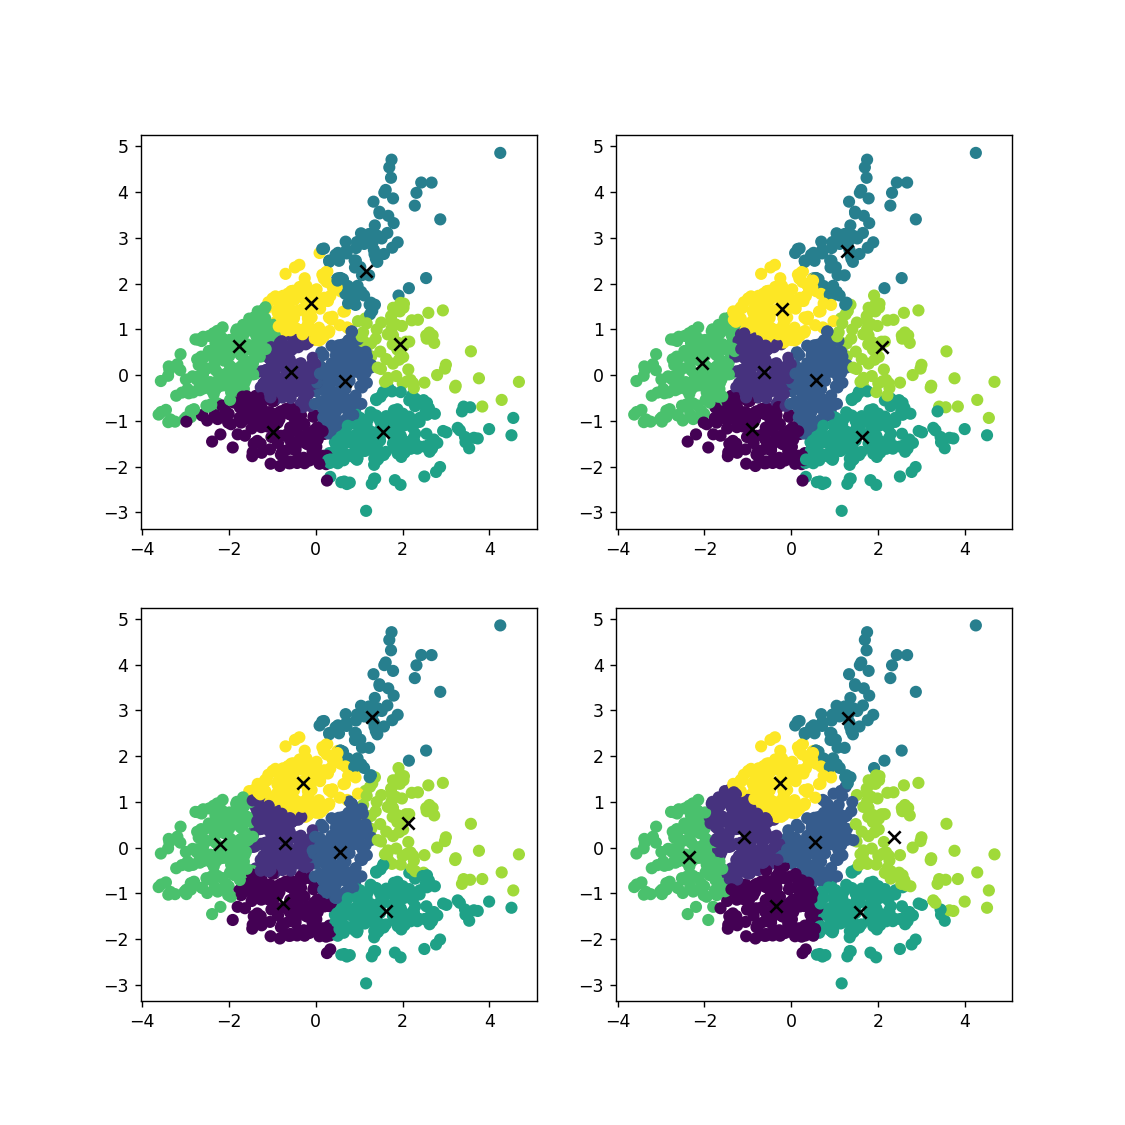

In [186]:
n_samples = 150
random_state = 180
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

iterations = [1,2,3,10]

fig2 = plt.figure(figsize=(9, 9))
plt.title("K-means iterations")
for i in range(len(iterations)):
    plt.subplot(2, 2, i+1)
    estimator = KMeans(init='random', n_clusters=8, random_state=170, n_init=1, max_iter=iterations[i])
    y_pred = estimator.fit_predict(X_PCA) 

    plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_pred)
    plt.scatter(estimator.cluster_centers_[:,0],estimator.cluster_centers_[:,1], s=50, marker='x', color="black")

<IPython.core.display.Javascript object>


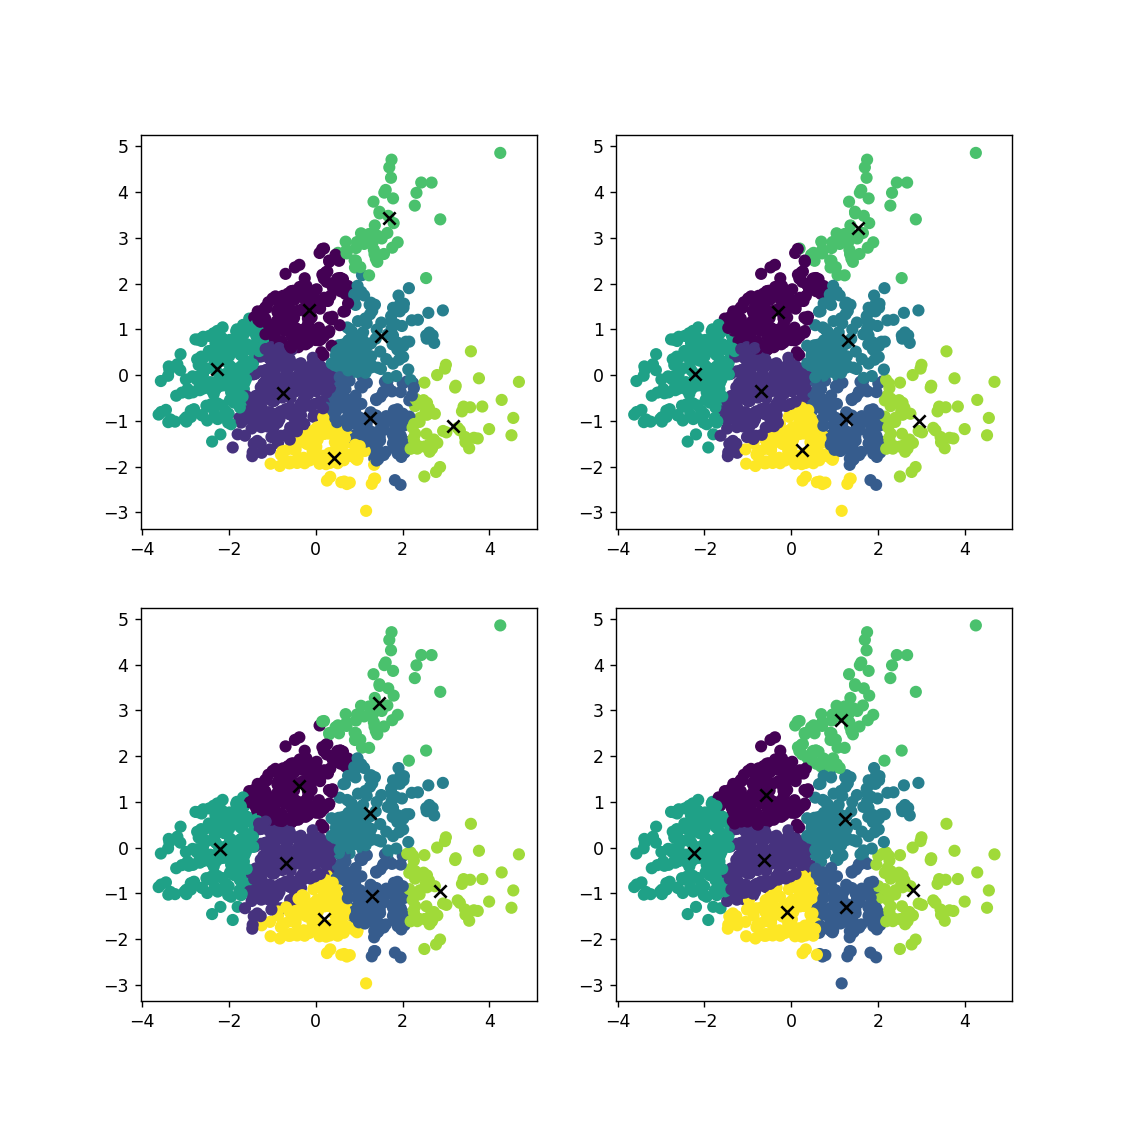

In [187]:
n_samples = 150
random_state = 180
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

iterations = [1,2,3,10]

fig2 = plt.figure(figsize=(9, 9))
plt.title("K-means iterations")
for i in range(len(iterations)):
    plt.subplot(2, 2, i+1)
    estimator = KMeans(init='k-means++', n_clusters=8, random_state=170, n_init=1, max_iter=iterations[i])
    y_pred = estimator.fit_predict(X_PCA) 
    plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_pred)
    plt.scatter(estimator.cluster_centers_[:,0],estimator.cluster_centers_[:,1], s=50, marker='x', color="black")

### Klasteriranje so hierarhiskiot model i pretstavuvanje preku dendogram

<IPython.core.display.Javascript object>


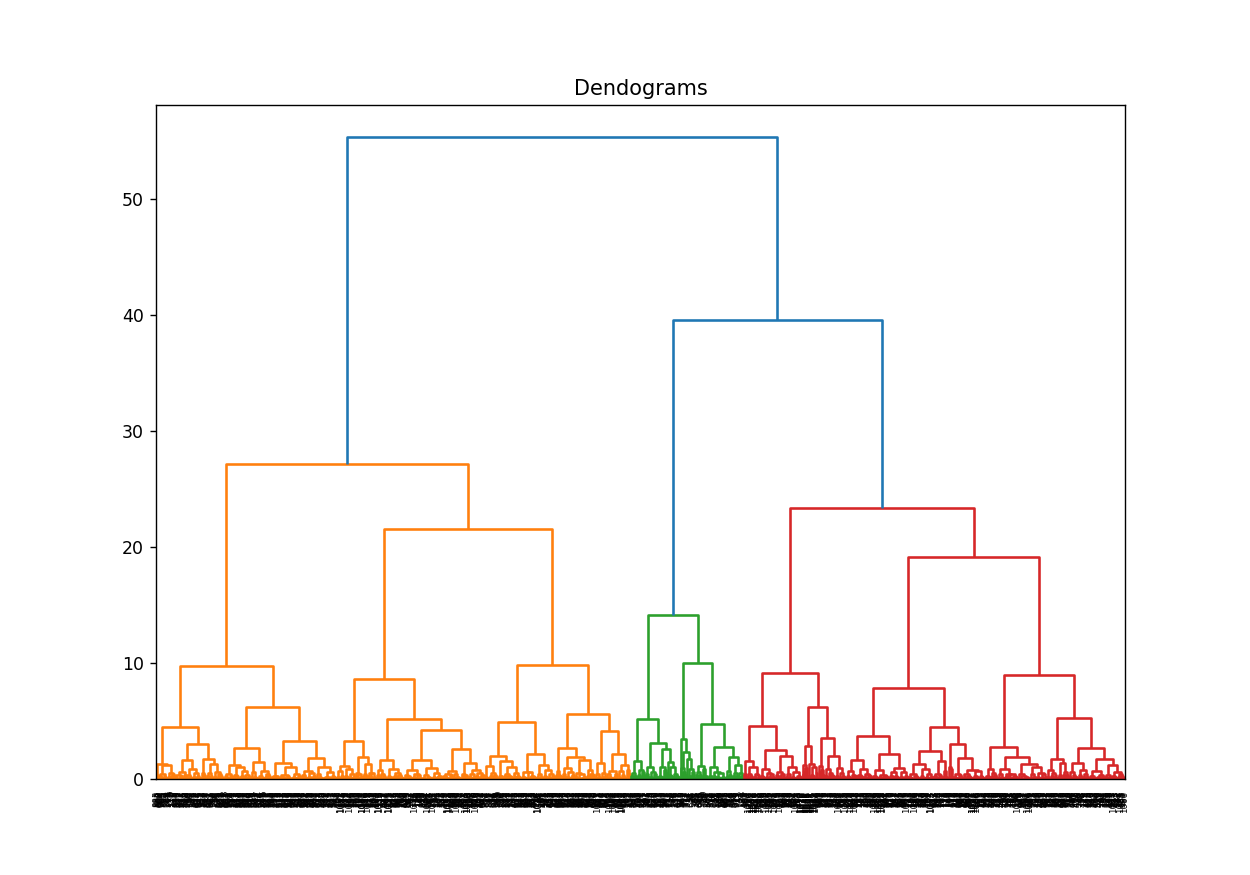

In [188]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Dendograms")
dend = shc.dendrogram(shc.linkage(X_PCA, method='ward'))

<IPython.core.display.Javascript object>


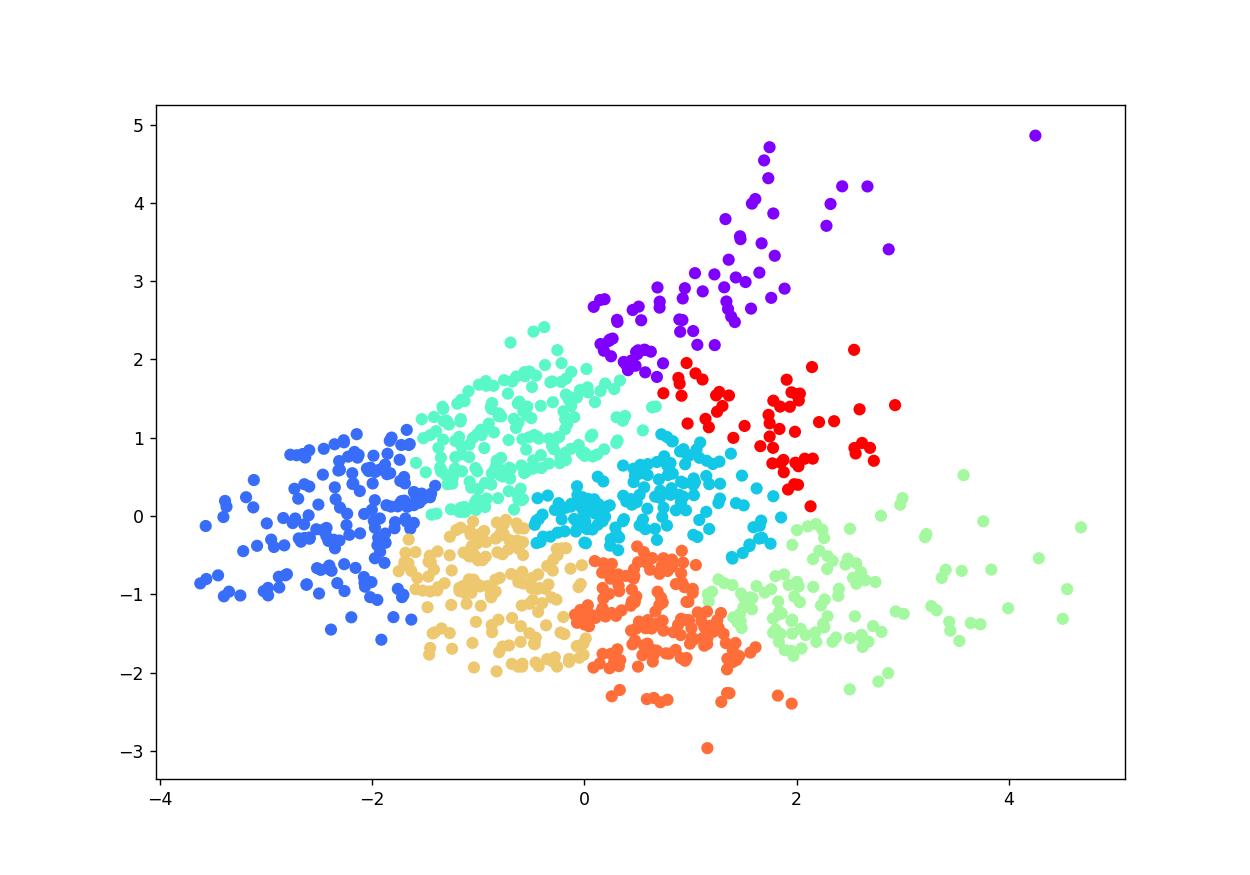

In [190]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')
cluster.fit_predict(X_PCA)

plt.figure(figsize=(10, 7))
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=cluster.labels_, cmap='rainbow')

### Klasteriranje so DBSCAN modelot za razlicni eps vrednosti i min broj na instanci=10

<IPython.core.display.Javascript object>


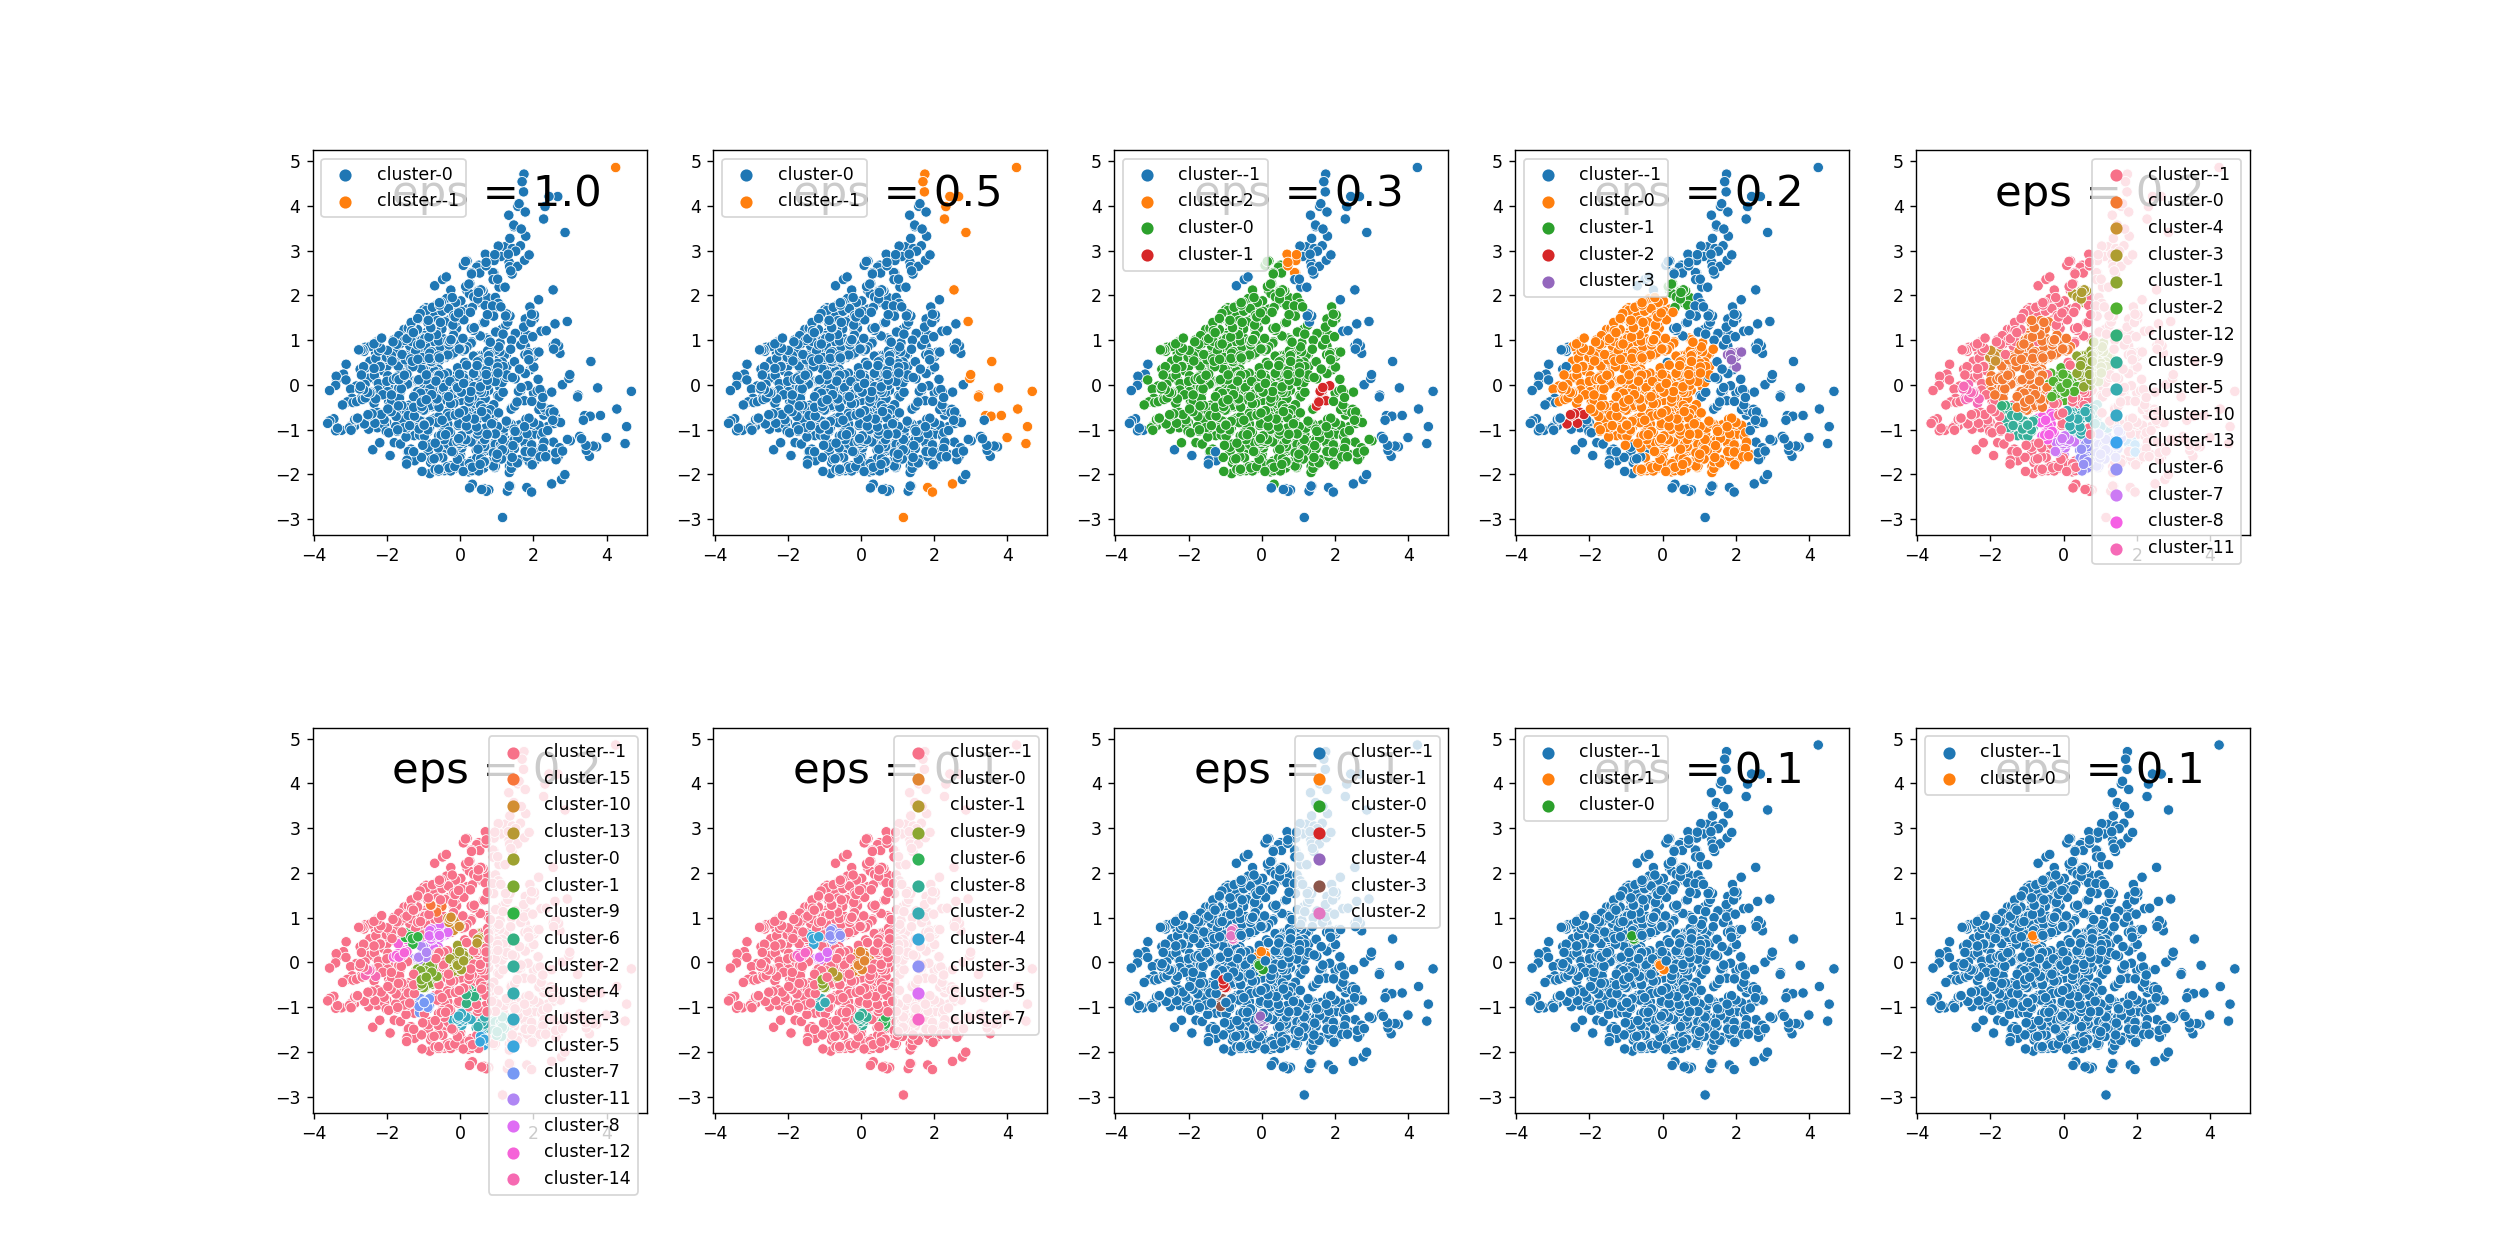

1.0
0.5
0.3333333333333333
0.25
0.2
0.16666666666666666
0.14285714285714285
0.125
0.1111111111111111
0.1


In [199]:
from sklearn.cluster import DBSCAN
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
for x in range(10, 0, -1):
    eps = 1/(11-x)
    db = DBSCAN(eps=eps, min_samples=10).fit(X_PCA)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    print(eps)
    ax = fig.add_subplot(2, 5, i)
    ax.text(1, 4, "eps = {}".format(round(eps, 1)), fontsize=25, ha="center")
    sns.scatterplot(X_PCA[:,0], X_PCA[:,1], hue=["cluster-{}".format(x) for x in labels])
    
    i += 1